In [132]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Assignment 3 - Jorge Clavijo

AI tools were used to improve the code

In [133]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    data_df = pd.read_csv(file_path, sep=";")
    # Sort the data by date and 5-minute interval
    data_df.sort_values(["Date", "Interval_5"], inplace=True)

    # Vectorize the daily data
    # Group the data by date
    day_subsets = data_df.groupby("Date")
    # Create a matrix where each row represents a day and each column represents a 5-minute interval
    vectorized_days = np.array([
        subset.set_index("Interval_5")["flow"].reindex(range(288)).values  # 288 intervals of 5 minutes in 24 hours
        for _, subset in day_subsets
    ])
    # Remove days with NaN values
    valid_days = ~np.isnan(vectorized_days).any(axis=1)  # Identify days without NaN values
    return vectorized_days[valid_days]  # Return only valid days


In [134]:
# 2. Clustering and Internal Evaluation
def perform_clustering(data, method, params):
    if method == 'KMeans':
        model = KMeans(n_clusters=params['n_clusters'], random_state=0, n_init='auto')
        clusters = model.fit(data)
        clusters_labels = clusters.labels_ if clusters is not None else None
    elif method == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=params['n_clusters'], metric='euclidean', linkage='ward')
        clusters = model.fit(data)
        clusters_labels = clusters.labels_ if clusters is not None else None
    elif method == 'GMM':
        model = GaussianMixture(n_components=params['n_clusters'], random_state=0)
        clusters_labels = model.fit(data).predict(data)
    elif method == 'DBSCAN':
        model = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        clusters = model.fit(data)
        clusters_labels = clusters.labels_ if clusters is not None else None

    # If there are no cluster labels, exit the function
    if clusters_labels is None:
        return

    # Calculate internal validation metrics
    if len(np.unique(clusters_labels)) > 1:
        # Silhouette Score (cohesion of clusters)
        silhouette = silhouette_score(data, clusters_labels)
        # Davies-Bouldin Score (separation and compactness)
        db_score = davies_bouldin_score(data, clusters_labels)
        # Calinski-Harabasz Score (dispersion within and between clusters)
        ch_score = calinski_harabasz_score(data, clusters_labels)
    else:
        silhouette = np.nan
        db_score = np.nan
        ch_score = np.nan

    # Return the model, labels, and calculated metrics
    return {
        'model': model,
        'labels': clusters_labels,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'model_type': method
    }

In [135]:
# 3. External Evaluation (Short-term Prediction Accuracy)
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    # Calculate the Euclidean distance between the new day and each centroid in the specified interval range
    distances = np.linalg.norm(
        centroids[:, from_interval:to_interval] - new_day[:, from_interval:to_interval],
        axis=1
    )
    closest_centroid = np.argmin(distances)
    return closest_centroid

def external_evaluation(model, test_data):
    # Obtain cluster labels for the test data using the trained model
    labels = model.predict(test_data) if hasattr(model, 'predict') else model.fit_predict(test_data)

    # If all points are noise (e.g., in DBSCAN), return NaN
    if np.all(labels == -1): 
        return {'MAE': np.nan, 'MAPE': np.nan}

    n_clusters = len(np.unique(labels))
    centroids = np.array([
        np.nanmean(test_data[labels == i], axis=0)
        for i in range(n_clusters) if np.sum(labels == i) > 0
    ])

    if len(centroids) == 0:
        return {'MAE': np.nan, 'MAPE': np.nan}

    n_past_intervals_for_classification = 5 

    total_mae = 0  # Total sum of Mean Absolute Error
    total_mape = 0  # Total sum of Mean Absolute Percentage Error
    prediction_counts = 0

    for i in range(len(test_data)):
        # Iterate over each time interval starting from the number of past intervals
        for j in range(n_past_intervals_for_classification, test_data.shape[1] - 1):
            # Find the closest centroid based on past intervals
            centroid_index = find_the_closest_centroid(
                centroids, 
                test_data[i].reshape(1, -1), 
                j - n_past_intervals_for_classification, 
                j
            )

            # Predict the value for the next interval using the closest centroid
            predicted_value = centroids[centroid_index, j + 1]
            actual_value = test_data[i, j + 1]

            if actual_value == 0:
                continue  
            mae_t = abs(predicted_value - actual_value)
            mape_t = abs(predicted_value - actual_value) / actual_value

            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1

    if prediction_counts == 0:
        return {'MAE': np.nan, 'MAPE': np.nan}

    mae = total_mae / prediction_counts
    mape = total_mape / prediction_counts

    return {'MAE': mae, 'MAPE': mape}

In [136]:
# 4. Visualization of Internal Metrics
def plot_internal_metrics(metrics, method, param_name):
    # Create a figure to plot the metrics
    plt.figure(figsize=(10, 6))
    # Iterate over the internal metrics
    for metric in ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']:
        # Plot each metric against the parameter (e.g., number of clusters)
        plt.plot(metrics[param_name], metrics[metric], label=metric)
    plt.xlabel(param_name.capitalize())  # X-axis label
    plt.ylabel('Score')  # Y-axis label
    plt.title(f'Internal Evaluation Metrics for {method}')  # Plot title
    plt.legend()  # Display legend
    plt.show()  # Show the plot

In [137]:
# 5. Main execution
# Load and preprocess data
data = load_and_preprocess_data("dataset_exercise_5_clustering_highway_traffic.csv")

max_clusters = 12 # Maximum number of clusters to test

# Define clustering methods and parameters
methods = ['KMeans', 'Agglomerative', 'GMM', 'DBSCAN']
params = {
    'KMeans': {'n_clusters': range(2, max_clusters+1)},
    'Agglomerative': {'n_clusters': range(2, max_clusters+1)},
    'GMM': {'n_clusters': range(2, max_clusters+1)},
    'DBSCAN': {'eps': [500, 1000, 1500, 2000], 'min_samples': range(2, 5)}
}

results = {method: [] for method in methods}

In [138]:
# Perform clustering and internal evaluation
for method in methods:
    if method != 'DBSCAN':
        for n_clusters in params[method]['n_clusters']:
            result = perform_clustering(data, method, {'n_clusters': n_clusters})
            results[method].append({**result, 'n_clusters': n_clusters})
    else:
        for eps in params[method]['eps']:
            for min_samples in params[method]['min_samples']:
                result = perform_clustering(data, method, {'eps': eps, 'min_samples': min_samples})
                results[method].append({**result, 'eps': eps, 'min_samples': min_samples})

In [139]:
# Load evaluation data
eval_data = load_and_preprocess_data("evaluation_dataset_exercise_5_clustering_highway_traffic.csv")

external_results = []
for method, runs in results.items():
    for run in runs:
        # Perform external evaluation
        external_metrics = external_evaluation(run['model'], eval_data)
        combined_results = {**run, **external_metrics}
        external_results.append(combined_results)

results_df = pd.DataFrame(external_results)

In [140]:
results_df_show = results_df.drop(columns=['labels'])
(results_df_show.sort_values(by=['model_type', 'Silhouette Score'], ascending=[True, False], inplace=True))

In [141]:
results_df_show

,model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score,model_type,n_clusters,MAE,MAPE,eps,min_samples
11,AgglomerativeClustering(),0.290945,1.279138,159.821505,Agglomerative,2.0,28.073462,0.367960,NaN,NaN
12,AgglomerativeClustering(n_clusters=3),0.268112,1.313811,148.607605,Agglomerative,3.0,26.699042,0.226119,NaN,NaN
14,AgglomerativeClustering(n_clusters=5),0.263778,1.231404,118.054696,Agglomerative,5.0,21.698308,0.186628,NaN,NaN
13,AgglomerativeClustering(n_clusters=4),0.257637,1.460274,127.187152,Agglomerative,4.0,23.527414,0.203224,NaN,NaN
15,AgglomerativeClustering(n_clusters=6),0.250363,1.460171,108.679506,Agglomerative,6.0,20.236522,0.166666,NaN,NaN
16,AgglomerativeClustering(n_clusters=7),0.243157,1.513606,100.749684,Agglomerative,7.0,19.932581,0.154570,NaN,NaN
17,AgglomerativeClustering(n_clusters=8),0.239635,1.440534,91.736572,Agglomerative,8.0,19.765820,0.153455,NaN,NaN
18,AgglomerativeClustering(n_clusters=9),0.233039,1.390687,84.412420,Agglomerative,9.0,19.163590,0.147708,NaN,NaN
19,AgglomerativeClustering(n_clusters=10),0.215062,1.415068,78.955196,Agglomerative,10.0,18.685767,0.143978,NaN,NaN
20,AgglomerativeClustering(n_clusters=11),0.192062,1.540013,74.390703,Agglomerative,11.0,18.350034,0.141787,NaN,NaN


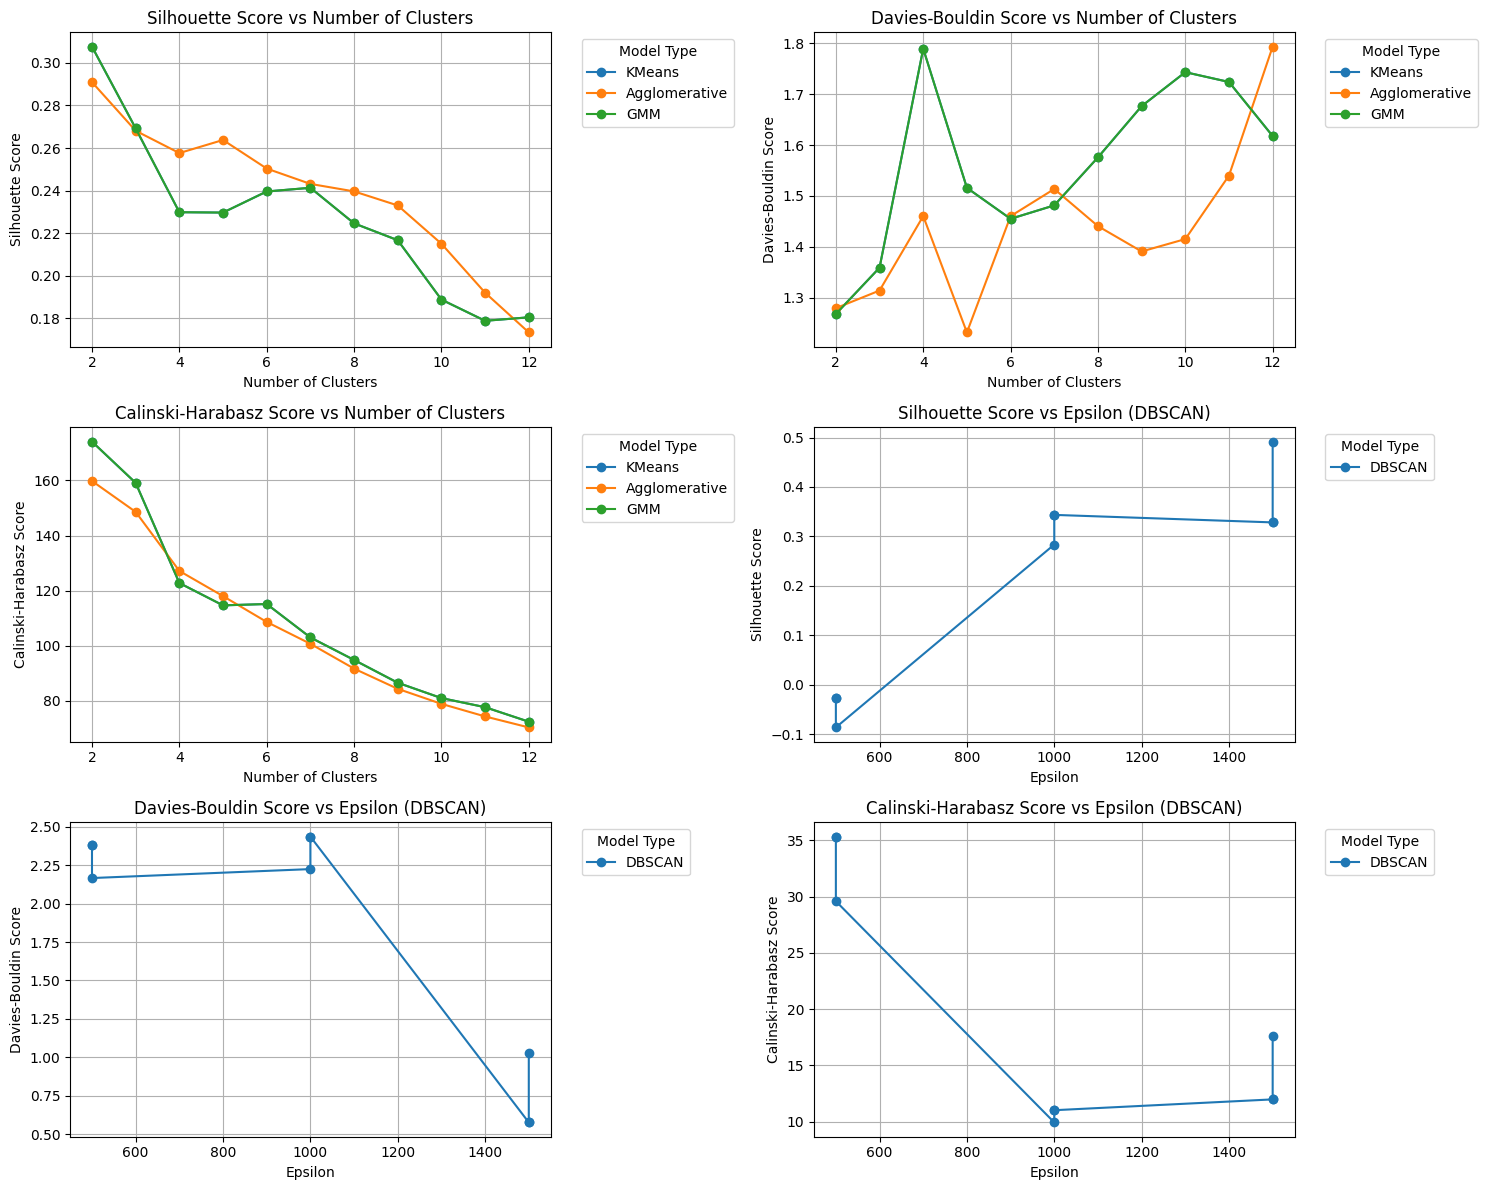

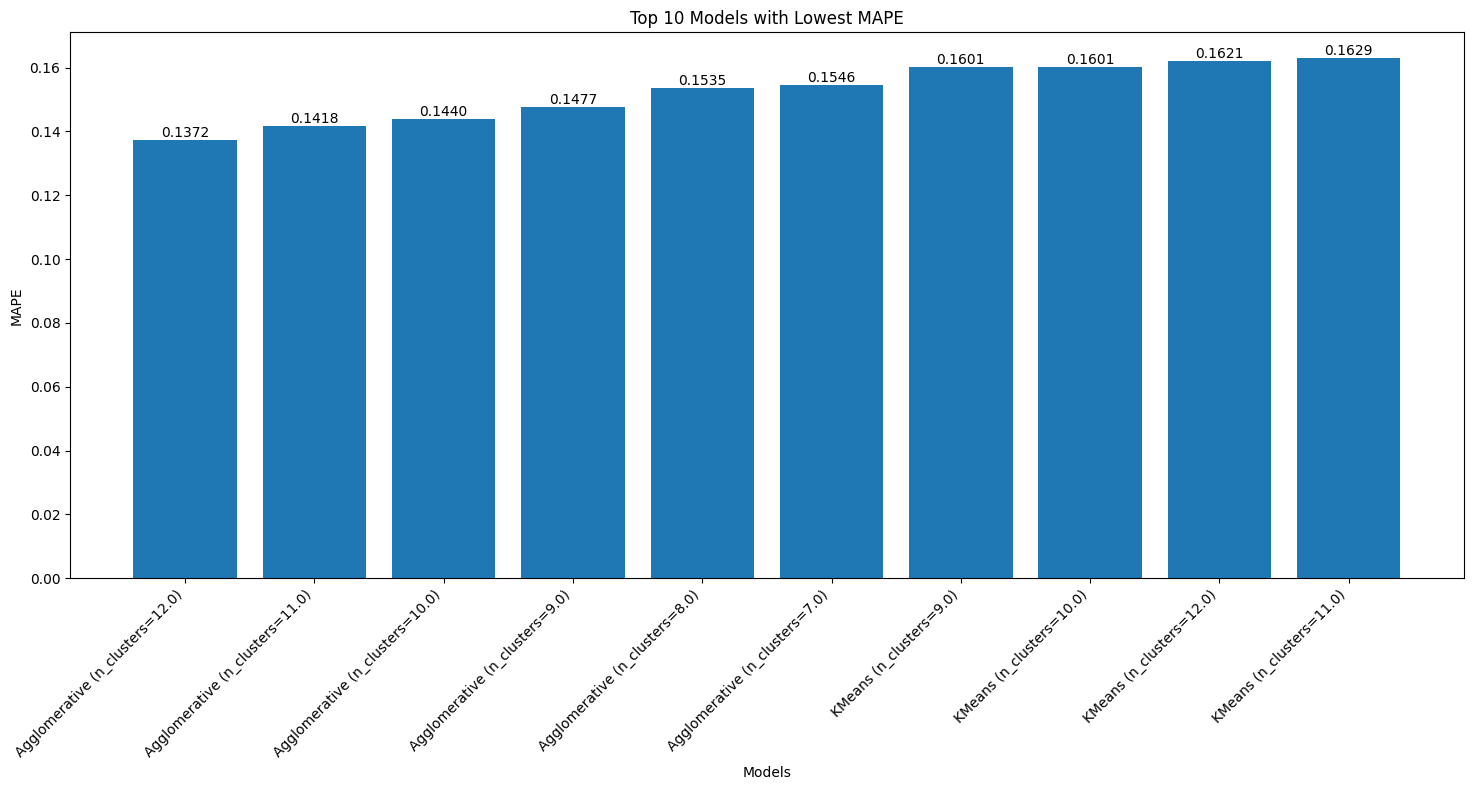

In [142]:
# Ploting Results
def plot_combined_elbow(data, x_column, y_column, title, xlabel, ylabel, subplot_position):
    plt.subplot(3, 2, subplot_position)
    for model_type in data['model_type'].unique():
        model_data = data[data['model_type'] == model_type].sort_values(x_column)
        plt.plot(model_data[x_column], model_data[y_column], marker='o', label=model_type)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)


# Combined plots for cluster-based models
cluster_models = results_df[results_df['model_type'].isin(['KMeans', 'Agglomerative', 'GMM'])]
metrics = ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']

plt.figure(figsize=(15, 12))
for i, metric in enumerate(metrics, start=1):
    plot_combined_elbow(cluster_models, 'n_clusters', metric,
                        f'{metric} vs Number of Clusters',
                        'Number of Clusters', metric, i)

# Plots for DBSCAN
dbscan_data = results_df[results_df['model_type'] == 'DBSCAN']

for i, metric in enumerate(metrics, start=4):
    plot_combined_elbow(dbscan_data, 'eps', metric,
                        f'{metric} vs Epsilon (DBSCAN)',
                        'Epsilon', metric, i)

plt.tight_layout()
plt.show()

# Create labels for each model
results_df['model_label'] = results_df.apply(lambda row: f"{row['model_type']} "
                                                         f"({'n_clusters' if row['model_type'] != 'DBSCAN' else 'eps'}="
                                                         f"{row['n_clusters'] if row['model_type'] != 'DBSCAN' else row['eps']})",
                                             axis=1)

# Sort data by MAPE in ascending order and take the top 10
sorted_data = results_df.sort_values('MAPE').head(10)

# Create bar chart for MAPE
plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(sorted_data)), sorted_data['MAPE'])
plt.title('Top 10 Models with Lowest MAPE')
plt.xlabel('Models')
plt.ylabel('MAPE')
plt.xticks(range(len(sorted_data)), sorted_data['model_label'], rotation=45, ha='right')

# Add MAPE values on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()